In [1]:
import cv2
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from utils import visualize, visualize_multiscale, map_class, parse_model_class_file, show_cam_on_image
from cam_techniques import AblationCAM

In [2]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

imgTransform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])


pathImgs = ['/mnt/nas/share/sagar/XAI/val_categorised/590/ILSVRC2012_val_00006215.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/591/ILSVRC2012_val_00006227.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/596/ILSVRC2012_val_00004802.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/667/ILSVRC2012_val_00009855.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/689/ILSVRC2012_val_00019027.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/764/ILSVRC2012_val_00011982.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/887/ILSVRC2012_val_00001805.JPEG',
           '/mnt/nas/share/sagar/XAI/val_categorised/1000/ILSVRC2012_val_00004949.JPEG']

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

vgg = models.vgg16(pretrained=True).eval().to(device)
layer = vgg.features[29]

ablationcamVGG = AblationCAM(vgg, layer)

In [4]:
imagenet_class_file = 'misc/map_clsloc.txt'
model_class_file = 'misc/imagenet1000_clsidx_to_labels.txt'

model_classes = parse_model_class_file(model_class_file)
model_classes.keys()

dict_keys(['ids', 'classnames'])

In [5]:
pathImg = pathImgs[0]

model_classid, class_name = map_class(int(pathImg.split('/')[-2]), imagenet_class_file, model_class_file)
print(model_classid, class_name)
#model_classes['classnames'][model_classid]

795 ski


In [6]:
imgPIL = Image.open(pathImg)
LRimgPIL = transforms.Resize(50)(imgPIL)
img = imgTransform(imgPIL).to(device).unsqueeze(0)
LRimg = imgTransform(LRimgPIL).to(device).unsqueeze(0)

[(-0.5, 499.5, 374.5, -0.5), (-0.5, 65.5, 49.5, -0.5)]

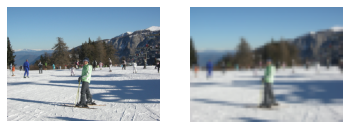

In [7]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(imgPIL)
ax[1].imshow(LRimgPIL)
[x.axis('off') for x in ax.ravel()]

In [8]:
def visualize_multiscale_new(img, LRimg, saliency_map, LRsaliency_map, labels, save_path=None):
    tx = transforms.Resize((224,224))
    img = np.array(tx(img))
    LRimg = np.array(tx(LRimg))
    saliency_map = tx(saliency_map.unsqueeze(0))[0].numpy()
    LRsaliency_map = tx(LRsaliency_map.unsqueeze(0))[0].numpy()
    
    use_rgb = True 

    fig, ax = plt.subplots(2,2)
    ax[0][0].imshow(img)
    ax[0][0].set_title('HR Input')
    ax[0][1].imshow(LRimg)
    ax[0][1].set_title('LR Input')
    ax[1][0].imshow(show_cam_on_image(img, saliency_map, use_rgb))
    ax[1][0].set_title('HR Output: '+ labels['hr'])
    ax[1][1].imshow(show_cam_on_image(LRimg, LRsaliency_map, use_rgb))
    ax[1][1].set_title('LR Output: '+ labels['lr'])
    [x.axis('off') for x in ax.ravel()]
    fig.suptitle('Method: AblationCAM. GT: '+ labels['gt'])

    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()        

In [9]:
ablationcamMap, logits = ablationcamVGG(img.to(device))
LRablationcamMap, LRlogits = ablationcamVGG(LRimg.to(device))

if not os.path.exists(os.path.join('outputs', class_name)):
    os.makedirs(os.path.join('outputs',class_name))

save_path = os.path.join('outputs', class_name, 'ablation_'+pathImg.split('/')[-1])    

pred = torch.argmax(logits)
LRpred = torch.argmax(LRlogits)
print(pred.item(), LRpred.item(), model_classid)
print('Predictions. HR: {}, LR: {}'.format(model_classes['classnames'][pred], model_classes['classnames'][LRpred]))

labels={'hr':model_classes['classnames'][pred], 'lr':model_classes['classnames'][LRpred], 'gt':model_classes['classnames'][model_classid]}

795 537 795
Predictions. HR: ski, LR: dogsled


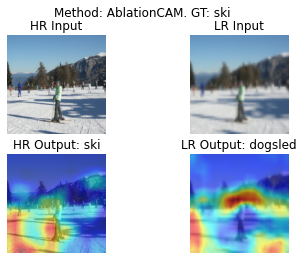

In [10]:
save_path = os.path.join('outputs', class_name, 'xgrad_'+pathImg.split('/')[-1]) 
visualize_multiscale_new(imgPIL, LRimgPIL, ablationcamMap.cpu(), LRablationcamMap.cpu(), labels)

In [15]:
imgPIL.size

(500, 375)

In [16]:
LRimgPIL.size

(133, 100)

In [17]:
500/133

3.7593984962406015

True: ski. Predictions. HR: ski, LR: ski
True: candle. Predictions. HR: candle, LR: candle
True: pier. Predictions. HR: barn, LR: mobile home
True: dishwasher. Predictions. HR: dishwasher, LR: parallel bars
True: boathouse. Predictions. HR: boathouse, LR: boathouse
True: modem. Predictions. HR: modem, LR: piggy bank
True: bullet train. Predictions. HR: streetcar, LR: bullet train
True: dumbbell. Predictions. HR: barbell, LR: dumbbell


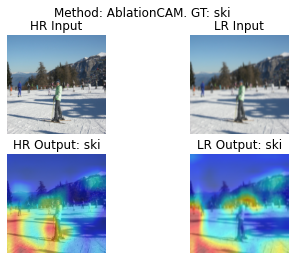

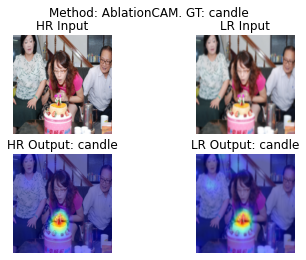

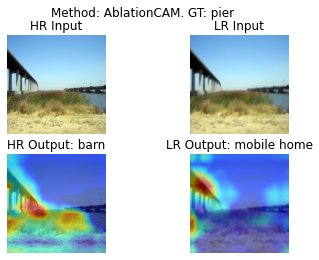

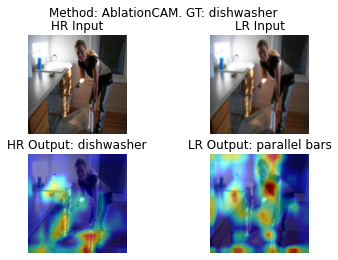

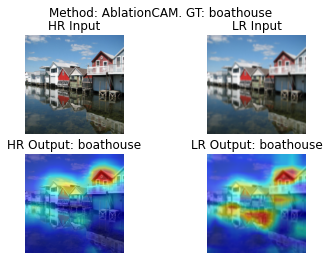

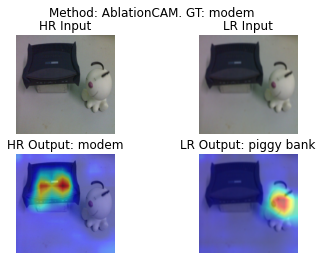

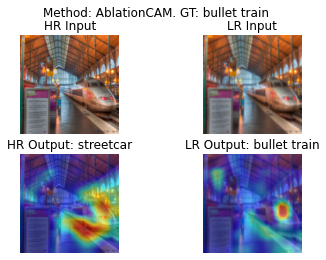

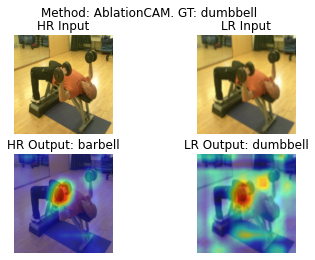

In [14]:
for pathImg in pathImgs:
    model_classid, class_name = map_class(int(pathImg.split('/')[-2]), imagenet_class_file, model_class_file)
    imgPIL = Image.open(pathImg)
    LRimgPIL = transforms.Resize(100)(imgPIL)
    img = imgTransform(imgPIL).to(device).unsqueeze(0)
    LRimg = imgTransform(LRimgPIL).to(device).unsqueeze(0)
    ablationcamMap, logits = ablationcamVGG(img.to(device))
    LRablationcamMap, LRlogits = ablationcamVGG(LRimg.to(device))

    if not os.path.exists(os.path.join('outputs', class_name)):
        os.makedirs(os.path.join('outputs',class_name))

    save_path = os.path.join('outputs', class_name, 'ablation_'+pathImg.split('/')[-1])    
    pred = torch.argmax(logits)
    LRpred = torch.argmax(LRlogits)
    
    #print(pred.item(), LRpred.item(), model_classid)
    #print('Predictions. HR: {}, LR: {}'.format(model_classes['classnames'][pred], model_classes['classnames'][LRpred]))

    labels={'hr':model_classes['classnames'][pred], 'lr':model_classes['classnames'][LRpred], 'gt':model_classes['classnames'][model_classid]}
    print('True: {}. Predictions. HR: {}, LR: {}'.format(
        class_name,
        model_classes['classnames'][pred], 
        model_classes['classnames'][LRpred]
    ))
    visualize_multiscale_new(imgPIL, LRimgPIL, ablationcamMap.cpu(), LRablationcamMap.cpu(), labels, save_path)